Problem: Heavy hitter

Reference:
- Privacy at Scale: Local Differential Privacy in Practice

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

Implementation of Random Response Protocol $\pi$ (for user with value $v$) as
\begin{equation}
  \forall_{y\in D} Pr[\pi(v)=y]=
  \begin{cases}
    \frac{e^\epsilon}{e^\epsilon+|D|-1}, & \text{if $y=v$}.\\
    \frac{1}{e^\epsilon+|D|-1}, & \text{if $y\neq v$}.\\
  \end{cases}
\end{equation}

Intuition: We sample the correct answer (response $y$ equals truth value $v$) with higher probability. Therefore, if $\epsilon$ is higher, probability of returning the correct answer is higher which means the privacy is lower. When $\epsilon = 0$, we have the highest privacy protection.

In [3]:
from heavyhitter import heavyhitter as hh
import numpy as np
class ROUser(hh.User):
  def set_epsilon(self, epsilon=0):
    self.eps = epsilon
    pk = [np.exp(self.eps) if np.array_equal(self.val, np.asarray([x])) else 1 
                                                 for x in self.rv.xk]
    pk /= np.exp(self.eps)+len(self.rv.xk)-1
    self.response_rv = stats.rv_discrete(name='response', values=(self.rv.xk, pk))
    
  def response(self, query):
    assert hasattr(self, 'response_rv'), "response requires setting privacy budget epsilon"
    return self.response_rv.rvs(size=1) == query
  
class ROAggregator(hh.Aggregator):
  def aggregate(self, responses):
    return np.mean(responses)

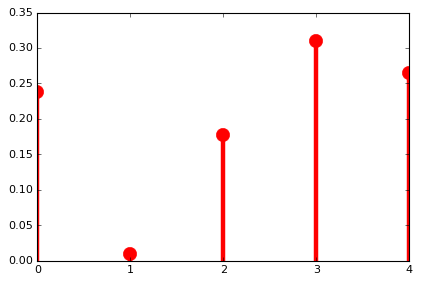

Generating 1000 samples
[(0, 251), (1, 9), (2, 194), (3, 298), (4, 248)]


In [4]:
from scipy import stats
import random

# create the random variable
domain_size = 5
domain = np.arange(domain_size)
prob = np.asarray([random.random() for _ in range(5)])
prob /= sum(prob)
rv = stats.rv_discrete(name='rv', values=(domain, prob))

# plot prob
plt.figure()
fig, ax = plt.subplots(1, 1)
ax.plot(domain, rv.pmf(domain), 'ro', ms=12, mec='r')
ax.vlines(domain, 0, rv.pmf(domain), colors='r', lw=4)
ax.set_xticks(domain)
plt.show()

# sanity check
from collections import Counter
c = Counter([sample for sample in rv.rvs(size=1000)])
print "Generating 1000 samples\n", list(c.items())

Frequency query with local Differential Privacy. The untrusted aggregator is trying to estimate the underlying true distribtion so it needs to query the users to report their values.

There are two sources of randomness
- Each user is a sample of the true distribution. 
- To protect their privacy, each user reports a random response.

Note that the randomness of the response in the equation depends on the domain size but not the number of users.

In [5]:
users = [ROUser(index=i, rv=rv) for i in range(1000)]
aggregator = ROAggregator(index=0)
aggregator.subscribe(users)

In [6]:
# Frequency query for elements
for eps in [0.0, 5.0]:
  for user in users:
    user.set_epsilon(epsilon=eps)
  print "==== %s users with epsilon=%s ===="%(len(users), users[0].eps)
  for x, p in zip(rv.xk, rv.pk):
    frequency = aggregator.aggregate(aggregator.query(np.asarray([x])))
    print "ele:%s, truth:%0.4f, estimate:%0.4f, diff:%0.4f"%(x,p,frequency, abs(p-frequency))

==== 1000 users with epsilon=0.0 ====
ele:0, truth:0.2380, estimate:0.1990, diff:0.0390
ele:1, truth:0.0092, estimate:0.1940, diff:0.1848
ele:2, truth:0.1772, estimate:0.1950, diff:0.0178
ele:3, truth:0.3103, estimate:0.2040, diff:0.1063
ele:4, truth:0.2653, estimate:0.2130, diff:0.0523
==== 1000 users with epsilon=5.0 ====
ele:0, truth:0.2380, estimate:0.2320, diff:0.0060
ele:1, truth:0.0092, estimate:0.0130, diff:0.0038
ele:2, truth:0.1772, estimate:0.1810, diff:0.0038
ele:3, truth:0.3103, estimate:0.2720, diff:0.0383
ele:4, truth:0.2653, estimate:0.3000, diff:0.0347
